In [ ]:
from __future__ import absolute_import, division, print_function

from tensorflow import keras
from tensorflow.keras import layers
import bisect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf

In [ ]:
from custom_layers import BiasOnly

In [ ]:
# J = ((x + b) - y)^2

In [144]:
def get_A_init(x, n=None):
    if n is None:
        n = 2 * x.shape[0]
    """
    x.shape() = (# features, # training)
    """
    box = np.array([x.min(axis=1), x.max(axis=1)]).transpose()
    assert box.shape == (x.shape[0], 2)
    k = 0
    A = []
    b = []
    n_boxes = n // (2 * x.shape[0])
    delta = .5 * (box[:, 1] - box[:, 0]) / n_boxes;
    while True:
        for side in range(x.shape[0]):
            for direction in (1,-1):
                if k >= n:
                    break
                k += 1
                A.append(np.zeros(x.shape[0]))
                A[-1][side] = float(direction)
                idx = -(direction - 1) // 2
                b.append(-direction * box[side][idx])
        if k >= n:
            break
        assert(all(delta >= 0.))
        box[:,0] += delta
        box[:,1] -= delta
        assert(all(box[:, 1] - box[:, 0] >= 0.))

    return np.array(A), np.array(b).reshape(n,1)


In [145]:
# x + 1
# -x + 4
# x - 1
# -x + 5
A, b = get_A_init(x, 15)
A.dot(x) + b

array([[ 3.  ,  0.  ,  4.  ,  5.  ,  4.  ],
       [ 2.  ,  5.  ,  1.  ,  0.  ,  1.  ],
       [ 4.  ,  3.  ,  2.  ,  1.  ,  0.  ],
       [ 0.  ,  1.  ,  2.  ,  3.  ,  4.  ],
       [ 0.  ,  2.  ,  0.  ,  2.  ,  0.  ],
       [ 2.  ,  0.  ,  2.  ,  0.  ,  2.  ],
       [ 1.75, -1.25,  2.75,  3.75,  2.75],
       [ 0.75,  3.75, -0.25, -1.25, -0.25],
       [ 3.  ,  2.  ,  1.  ,  0.  , -1.  ],
       [-1.  ,  0.  ,  1.  ,  2.  ,  3.  ],
       [-0.5 ,  1.5 , -0.5 ,  1.5 , -0.5 ],
       [ 1.5 , -0.5 ,  1.5 , -0.5 ,  1.5 ],
       [ 0.5 , -2.5 ,  1.5 ,  2.5 ,  1.5 ],
       [-0.5 ,  2.5 , -1.5 , -2.5 , -1.5 ],
       [ 2.  ,  1.  ,  0.  , -1.  , -2.  ]])

In [124]:
x = 1.* np.array([[2,-1,3,4,3], [5,4,3,2,1], [-1,1,-1,1,-1]])
x

array([[ 2., -1.,  3.,  4.,  3.],
       [ 5.,  4.,  3.,  2.,  1.],
       [-1.,  1., -1.,  1., -1.]])

In [120]:
box = np.array([x.min(axis=1), x.max(axis=1)]).transpose()
box

array([[-1.,  4.],
       [ 1.,  5.],
       [-1.,  1.]])

In [128]:
delta = box[:, 1] - box[:, 0]
delta >= 0

array([ True,  True,  True])

In [78]:
x = np.array([1., 2, 3, 4]).reshape(4,1)
y = np.array([5., 0, 3, -1]).reshape(4,1)
model = keras.Sequential()
# model.add(layers.Flatten(input_shape=(2,2)))
model.add(BiasOnly(1))
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.RMSprop(.1))
h = model.fit(x, y, epochs=100, verbose=0)

In [52]:
h.history['loss'][-10:]

[10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875,
 10.6875]

In [53]:
model.get_weights()

[array([-0.75000006], dtype=float32)]

In [34]:
y.mean() - x.mean()

-0.75

In [72]:
def f(m, n):
    v = [1.] * n
    return pinv(np.array([v] * m))[0][0]

In [76]:
for m in range(1,5):
    for n in range(1,5):
        print('f({},{}) = {}, guess={}'.format(m, n, f(m,n), 1./(float(m)*n)))

f(1,1) = 1.0, guess=1.0
f(1,2) = 0.4999999999999998, guess=0.5
f(1,3) = 0.33333333333333337, guess=0.3333333333333333
f(1,4) = 0.25, guess=0.25
f(2,1) = 0.4999999999999998, guess=0.5
f(2,2) = 0.24999999999999992, guess=0.25
f(2,3) = 0.1666666666666666, guess=0.16666666666666666
f(2,4) = 0.12499999999999994, guess=0.125
f(3,1) = 0.33333333333333337, guess=0.3333333333333333
f(3,2) = 0.1666666666666666, guess=0.16666666666666666
f(3,3) = 0.11111111111111102, guess=0.1111111111111111
f(3,4) = 0.08333333333333334, guess=0.08333333333333333
f(4,1) = 0.25, guess=0.25
f(4,2) = 0.12499999999999996, guess=0.125
f(4,3) = 0.08333333333333337, guess=0.08333333333333333
f(4,4) = 0.06250000000000004, guess=0.0625


In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    #plt.ylim([0,5])
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
from solver import solve

In [ ]:
help(tf.nn.leaky_relu)

In [ ]:
def build_model():
    model = keras.Sequential([
        #layers.Dense(10, kernel_regularizer=keras.regularizers.l2(0.001),
        #             activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        #layers.Dense(2)
        layers.Dense(1, input_shape=[1])
    ])

    optimizer = tf.keras.optimizers.Adam(0.1)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model() if 'model' not in dir() else model

In [ ]:
model.summary()

In [ ]:
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 100

class PrintDot(keras.callbacks.Callback):
    def __init__(self):
        self.i = 0
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch > 0: print('{}%'.format(int(epoch*100/EPOCHS)))
        print(str(self.i), end='')
        self.i = (self.i + 1) % 10
        
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(
    x[0], y[0],
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stop, PrintDot()])

In [ ]:
model.get_weights()

In [ ]:
A, b

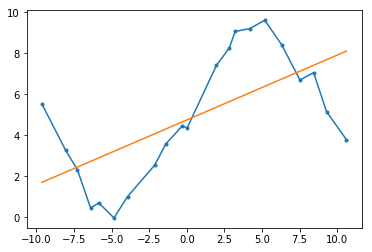

In [147]:
from solver import solve
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from tensorflow.keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

def fun(x):
    if x < -5:
        return -(x + 5.)
    if x < 5:
        return x + 5.
    return -x + 15.

np_fun = np.vectorize(fun)

x = (np.arange(-10.,11) + np.random.rand(21)).reshape(1,21)
# y = 0.3 * x + np.random.rand(21) + 1
np.random.seed(3)
y = np_fun(x) + np.random.normal(scale=.5, size=len(x[0]))

A, b = solve(x, y)

plt.plot(x[0], y[0], '.-')
# plt.plot(x[0], model.predict(x[0])[:,0])
plt.plot(x[0], (A.dot(x) + b)[0])

In [ ]:
def extend(x):
    return np.concatenate((x,x*x,x**3)).transpose()

In [261]:
np.array(list([[1,2,3]])).shape

(1, 3)

In [258]:
import custom_layers
import importlib
importlib.reload(custom_layers)
from custom_layers import RELUInitializer

def build_model2():
    # model_in = layers.Input(shape=(1,)) 
    rinit = RELUInitializer(x, y, 5)
    model = keras.Sequential([
        layers.Dense(5,
                     input_shape=(1,),
                     activation=tf.nn.relu,
                     kernel_initializer=rinit.get_A,
                     bias_initializer=rinit.get_b),
                     #),
        layers.Dense(1,
                     kernel_initializer=rinit.get_C,
                     bias_initializer=rinit.get_d)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.1)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

if 'model2' in dir():
    del model2
model2 = build_model2()
EPOCHS = 1000
class PrintDot(keras.callbacks.Callback):
    def __init__(self):
        self.i = 0
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch > 0: print('{}%'.format(int(epoch*100/EPOCHS)))
        print('.', end='')
        self.i = (self.i + 1) % 10
        
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

history = model2.fit(
    x[0], y[0],
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stop, PrintDot()])

ValueError: Shapes differ: (this) (1, 1) != (1,) (arg)

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

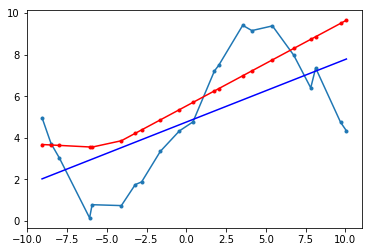

In [237]:
x = (np.arange(-10.,11) + np.random.rand(21)).reshape(1,21)
# y = 0.3 * x + np.random.rand(21) + 1
np.random.seed(3)
y = np_fun(x) + np.random.normal(scale=.5, size=len(x[0]))

A, b = solve(x, y)

plt.plot(x[0], y[0], '.-')
plt.plot(x[0], model2.predict(x[0])[:,0], '.-r')
plt.plot(x[0], (A.dot(x) + b)[0], 'b')

In [ ]:
model2.summary()

In [ ]:
plot_history(history)

In [ ]:
pd.DataFrame(history.history).tail()

In [ ]:
pd.DataFrame(history.history).tail()